# Trabalho 4

##### Aluno: Leodécio Braz
##### Ra: 230219

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
name_images = [('foto1','./imagens_registro/foto1A.jpg','./imagens_registro/foto1B.jpg'),
               ('foto2','./imagens_registro/p1A.jpeg','./imagens_registro/p1B.jpeg'),
               ('foto3','./imagens_registro/foto4A.jpg','./imagens_registro/foto4B.jpg'),
               ('foto4','./imagens_registro/foto2A.jpg','./imagens_registro/foto2B.jpg'),
               ('foto5','./imagens_registro/foto3A.jpg','./imagens_registro/foto3B.jpg'),
               ('foto6','./imagens_registro/foto5A.jpg','./imagens_registro/foto5B.jpg'),
               ('foto7','./imagens_registro/p2A.jpeg','./imagens_registro/p2B.jpeg')]

# para alterar a imagem basta mudar o indide para algum em names_images
indice = 0
image = name_images[indice]

metodos = ['SURF','SIFT','BRIEF','ORB']

# para alterar o descritor basta mudar o valor abaixo para algum em 'metodos'
metodo = metodos[0]

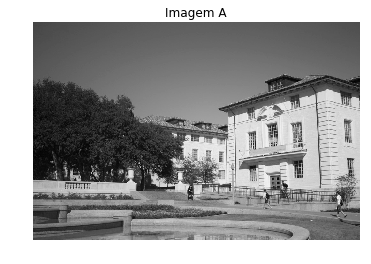

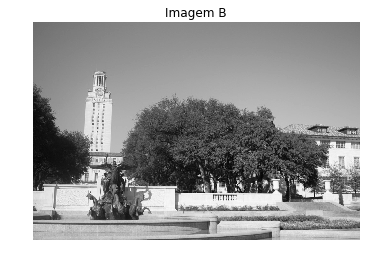

In [3]:
imageA = cv2.imread(image[1])
imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
imgGrayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)

imageB = cv2.imread(image[2])
imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
imgGrayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

plt.title('Imagem A')
plt.imshow(imgGrayA,cmap='gray')
plt.axis('off')
plt.show()

plt.title('Imagem B')
plt.imshow(imgGrayB,cmap='gray')
plt.axis('off')
plt.show()

### Funções auxiliares

In [4]:
def descriptors(image,name = 'SIFT'):
    if name == 'SIFT':
        sift = cv2.xfeatures2d.SIFT_create()
        kps,descs = sift.detectAndCompute(image, None)
        kps_ = np.float32([kp.pt for kp in kps])
        return kps,kps_, descs
    elif name == 'SURF':
        surf = cv2.xfeatures2d.SURF_create()
        kps,descs = surf.detectAndCompute(image, None)
        kps_ = np.float32([kp.pt for kp in kps])
        return kps,kps_, descs
    elif name == 'BRIEF':
        star = cv2.xfeatures2d.StarDetector_create()
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        # Encontra os keypoints com o STAR
        kp = star.detect(image,None)
        # computa os descritores com BRIEF
        kps,descs = brief.compute(image,kp)
        kps_ = np.float32([kp.pt for kp in kps])
        return kps, kps_, descs
    elif name == 'ORB':
        orb = cv2.ORB_create()
        # compute the descriptors with ORB
        kps, descs = orb.detectAndCompute(image, None)
        kps_ = np.float32([kp.pt for kp in kps])
        return kps, kps_, descs

In [5]:
def computar_dist(descsA, descsB):
    ## Realiza um match dos Keypoints
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    matches = matcher.knnMatch(descsA, descsB, k=2)
    
    return matches

#### Gerando os descritores das duas imagens

In [6]:
_kpa, kpsA, descsA = descriptors(imgGrayA, metodo)
_kpb, kpsB, descsB = descriptors(imgGrayB, metodo)

##### Visualizar Keypoints

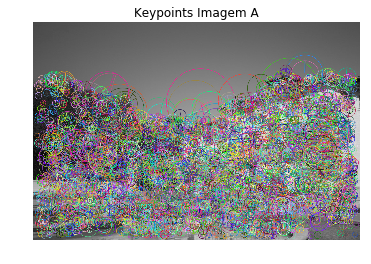

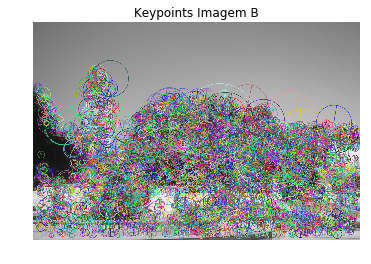

In [7]:
img_kpa = cv2.drawKeypoints(imgGrayA,_kpa,imgGrayA, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kpb = cv2.drawKeypoints(imgGrayB,_kpb,imgGrayB, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.title('Keypoints Imagem A')
plt.imshow(img_kpa)
plt.axis('off')
plt.show()

plt.title('Keypoints Imagem B')
plt.imshow(img_kpb)
plt.axis('off')
plt.show()

In [8]:
#Função para computar a distância entre os descritores 
matches = computar_dist(descsA,descsB)

#Valor de threshold
tresh = 0.75

good = []
#calcula as melhores correspondencias
for m,n in matches:
    if m.distance < n.distance * tresh:
        good.append([m.trainIdx, m.queryIdx])

if len(good) >= 4:
    # Pega os keypoints que pertencem à melhor correspondencia
    ptsA = np.float32([kpsA[i] for (_, i) in good])
    ptsB = np.float32([kpsB[i] for (i, _) in good])
    
    # Calcula a matrix de homografia entre os dois conjunto de pontos
    H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4.0)
    print("Matriz de Homografia : \n"+ str(H))
else:
    print("Não foi possível encontrar correspondencias")

Matriz de Homografia : 
[[ 7.59087598e-01  3.83337755e-02  4.47530724e+02]
 [-1.38730238e-01  9.11533487e-01  7.68362206e+01]
 [-2.17528651e-04 -3.02415919e-05  1.00000000e+00]]


In [9]:
#Projeção de perspectiva para alinhar as imagens
result = cv2.warpPerspective(imageA,H,(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

In [10]:
## Desenha retas entre pontos correspondentes no par de imagens.
heightA, widthA = imgGrayA.shape
heightB, widthB = imgGrayB.shape

visualize = np.zeros((max(heightA, heightB), widthA + widthB, 3), dtype="uint8")
visualize[0:heightA, 0:widthA] = imageA
visualize[0:heightB, widthA:] = imageB

for ((trainIdx, queryIdx), s) in zip(good, status):
    # somente desenha uma reta se os keypoints tiverem tido um match 
    if s == 1:
        ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
        ptB = (int(kpsB[trainIdx][0]) + widthA, int(kpsB[trainIdx][1]))
        cv2.line(visualize, ptA, ptB, (0, 255, 0), 1)

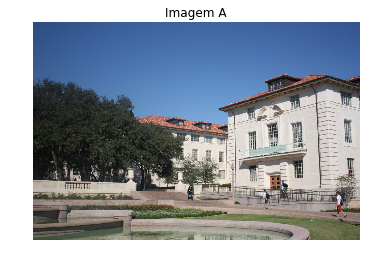

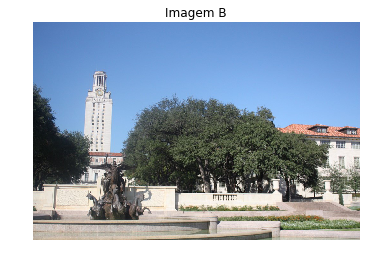

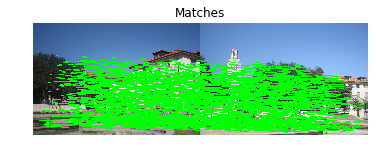

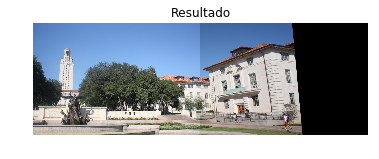

In [11]:
plt.title("Imagem A")
plt.axis('off')
plt.imshow(imageA)
plt.show()

plt.title("Imagem B")
plt.axis('off')
plt.imshow(imageB)
plt.show()

plt.title("Matches")
plt.axis('off')
plt.imshow(visualize)
plt.imsave("./output/"+image[0]+"_"+metodo+"_matches.jpeg",visualize)
plt.show()

plt.title("Resultado")
plt.axis('off')
plt.imshow(result)
plt.imsave("./output/"+image[0]+"_"+metodo+"_resultado.jpeg",result)
plt.show()